In [5]:
from sklearn.metrics import silhouette_score, davies_bouldin_score
import torch.nn as nn
import sys
import os
project_root = os.path.abspath("..")  # Adjust if needed
import pytorch_lightning as pl
# Add the project root to sys.path
if project_root not in sys.path:
    sys.path.append(project_root)
from collections import Counter

from src.utils.data_utils import *
from src.dataset_classes.pointDataset import *
from proteinshake.datasets import ProteinFamilyDataset
from proteinshake.tasks import LigandAffinityTask
import random
from src.models.graphVAE import GraphVAE
from src.models.basicVae import LitBasicVae
from src.models.PointNetVae_chamfer_split import PointNetVAE
from torch.utils.data import Dataset, Subset
from torch_geometric.utils import to_dense_batch, to_dense_adj
import numpy as np
from src.utils.data_utils import *
from src.dataset_classes.graphDataset import *
from src.dataset_classes.sequenceDataset import *
from torch_geometric.loader import DataLoader as Pyg_DataLoader
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Get Protein Family Labels

In [6]:
data = ProteinFamilyDataset(root='../data').to_point().torch()
graph_data = ProteinFamilyDataset(root='../data').to_graph(eps = 8).pyg()
seq_dataset = SequenceDataset(data, 500, return_proteins=True)
seq_dataloader = DataLoader(seq_dataset, batch_size = 128)

point_dataset = PointDataset(data, 500, return_proteins = True)
point_dataloader = DataLoader(point_dataset, batch_size = 128)

### NEED TO USE PYG-DATALOADER ###
graph_dataset  = load_graph_data(graph_data, amnino_acids=20)
graph_dataloader = Pyg_DataLoader(graph_dataset, batch_size=128, shuffle=True)

families = [k[1]['protein']['Pfam'][0] for k in seq_dataset.org_protein_data]

# Count occurrences of each element
counter = Counter(families)

100%|██████████| 31109/31109 [00:08<00:00, 3510.08it/s]


In [7]:
counter.most_common(100)

[('PF00069', 431),
 ('PF00959', 356),
 ('PF07714', 286),
 ('PF00565', 262),
 ('PF00067', 240),
 ('PF00062', 217),
 ('PF00076', 198),
 ('PF01353', 198),
 ('PF00042', 180),
 ('PF00595', 176),
 ('PF00061', 171),
 ('PF00071', 171),
 ('PF13499', 162),
 ('PF00089', 161),
 ('PF00194', 160),
 ('PF00096', 154),
 ('PF13354', 149),
 ('PF00018', 125),
 ('PF00001', 119),
 ('PF00041', 107),
 ('PF00210', 102),
 ('PF00102', 101),
 ('PF00561', 99),
 ('PF00072', 98),
 ('PF00085', 95),
 ('PF00074', 93),
 ('PF07686', 92),
 ('PF00248', 88),
 ('PF00017', 87),
 ('PF00240', 86),
 ('PF00104', 85),
 ('PF07679', 84),
 ('PF00439', 84),
 ('PF13561', 84),
 ('PF00082', 79),
 ('PF00141', 79),
 ('PF00583', 78),
 ('PF00397', 76),
 ('PF00753', 74),
 ('PF02518', 73),
 ('PF00254', 73),
 ('PF00550', 69),
 ('PF00127', 69),
 ('PF00704', 67),
 ('PF00293', 65),
 ('PF00377', 65),
 ('PF00155', 65),
 ('PF00186', 64),
 ('PF00068', 63),
 ('PF00034', 61),
 ('PF00144', 60),
 ('PF00258', 58),
 ('PF07732', 58),
 ('PF00451', 58),
 ('PF0

In [8]:
len(seq_dataset)

28733

In [9]:
len(graph_dataset)

28733

# Run Inference on dataset and save results from models

In [10]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

In [11]:
seq_checkpoint_path = '../trained_models/Pfam/BVAE/FINAL_MODEL/LD16_HD512_Beta0.005_BetaInc0.ckpt'
point_checkpoint_path = "../trained_models/Pfam/PVAE/FINAL_MODEL/FINAL_PVAE_LD64_GF512_BetaInc0_Beta0.005_HD512_CH8.ckpt"
graph_checkpoint_path = '../trained_models/Pfam/GVAE/2_LD32_HD512_Beta0.005_GCH96_LR0.0001.ckpt'

seq_model = LitBasicVae.load_from_checkpoint(seq_checkpoint_path)
point_model = PointNetVAE.load_from_checkpoint(point_checkpoint_path)
graph_model = GraphVAE.load_from_checkpoint(graph_checkpoint_path)

# Put model in evaluation mode
seq_model.eval()
point_model.eval()
graph_model.eval()
graph_model.to(device)


/opt/anaconda3/envs/ProteinManifoldLearning/lib/python3.10/site-packages/pytorch_lightning/core/module.py:441: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`
/opt/anaconda3/envs/ProteinManifoldLearning/lib/python3.10/site-packages/pytorch_lightning/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.5.1, which is newer than your current Lightning version: v2.5.0.post0


GraphVAE(
  (conv1): GCNConv(20, 96)
  (conv2): GCNConv(96, 192)
  (fc_mu): Linear(in_features=96000, out_features=32, bias=True)
  (fc_logvar): Linear(in_features=96000, out_features=32, bias=True)
  (fc1_dec): Linear(in_features=32, out_features=512, bias=True)
  (fc2_dec_feature): Linear(in_features=512, out_features=10000, bias=True)
  (fc_adj_dec): Linear(in_features=32, out_features=96000, bias=True)
  (tanh): Tanh()
  (sigmoid): Sigmoid()
  (soft): Softmax(dim=-1)
)

In [12]:
from tqdm import tqdm

seq_latent_coord = []
for batch in tqdm(seq_dataloader):
    rep_z, x_mu, x_logvar, x_rec, logit = seq_model(batch.to(device))
    seq_latent_coord.append(x_mu.detach().cpu().numpy())

seq_latent_coord = np.concatenate(seq_latent_coord, axis = 0)

point_latent_coord = []
for batch in tqdm(point_dataloader):
    rep_z, x_mu, x_logvar, x_rec, logit = point_model(batch.to(device))
    point_latent_coord.append(x_mu.detach().cpu().numpy())

point_latent_coord = np.concatenate(point_latent_coord, axis = 0)

graph_latent_coord = []
for batch in tqdm(graph_dataloader):
    rep_z, x_mu, x_logvar, x_rec, logit_feature, adj_matrix  = graph_model(batch.to(device))
    graph_latent_coord.append(x_mu.detach().cpu().numpy())
graph_latent_coord = np.concatenate(graph_latent_coord, axis = 0)

100%|██████████| 225/225 [01:08<00:00,  3.29it/s]


In [13]:
# Save results to arrays
np.save('../data/Cluster_Analysis_Data/seq_data.npy', seq_latent_coord)
np.save('../data/Cluster_Analysis_Data/point_data.npy',  point_latent_coord)
np.save('../data/Cluster_Analysis_Data/graph_data.npy', graph_latent_coord)

# Load in data results

In [14]:
seq_result = np.load('../data/Cluster_Analysis_Data/seq_data.npy')
point_result = np.load('../data/Cluster_Analysis_Data/point_data.npy')
graph_result = np.load('../data/Cluster_Analysis_Data/graph_data.npy')

In [15]:
seq_result.shape

(28733, 16)

# Get Most common Families to begin analysis

In [16]:
top_families = [i[0] for i in counter.most_common(10)[:]]
top_family_indices = np.array([idx for idx, k in enumerate(seq_dataset.org_protein_data) if k[1]['protein']['Pfam'][0] in top_families])
top_family_labels = np.array([k[1]['protein']['Pfam'][0] for idx, k in enumerate(seq_dataset.org_protein_data) if k[1]['protein']['Pfam'][0] in top_families])

In [17]:
top_prot_dict = dict(zip(list(np.unique(top_family_labels)), list(np.array([i for i in range(20)]))))

seq_latent_vectors = seq_result[top_family_indices,:]
point_latent_vectors = point_result[top_family_indices, :]
graph_latent_vectors = graph_result[top_family_indices, :]

latent_results = [seq_latent_vectors, point_latent_vectors, graph_latent_vectors]

for i in latent_results:
    sil_score = silhouette_score(i, top_family_labels)
    db_score = davies_bouldin_score(i, top_family_labels)
    print(f"Silhouette Score: {sil_score:.3f}, Davies-Bouldin Index: {db_score:.3f}")

Silhouette Score: 0.127, Davies-Bouldin Index: 3.272
Silhouette Score: 0.074, Davies-Bouldin Index: 4.864
Silhouette Score: -0.045, Davies-Bouldin Index: 24.872


In [18]:
projected_data_results = []

for i in latent_results:

    U, S, V = torch.pca_lowrank(torch.tensor(i), q=None, center=True, niter=2)
    projected_data = torch.matmul(torch.tensor(i), V[:, :2]).numpy()
    projected_data_results.append(projected_data)

In [26]:
np.unique(top_family_labels)[:10]

array(['PF00042', 'PF00062', 'PF00067', 'PF00069', 'PF00076', 'PF00565',
       'PF00595', 'PF00959', 'PF01353', 'PF07714'], dtype='<U7')

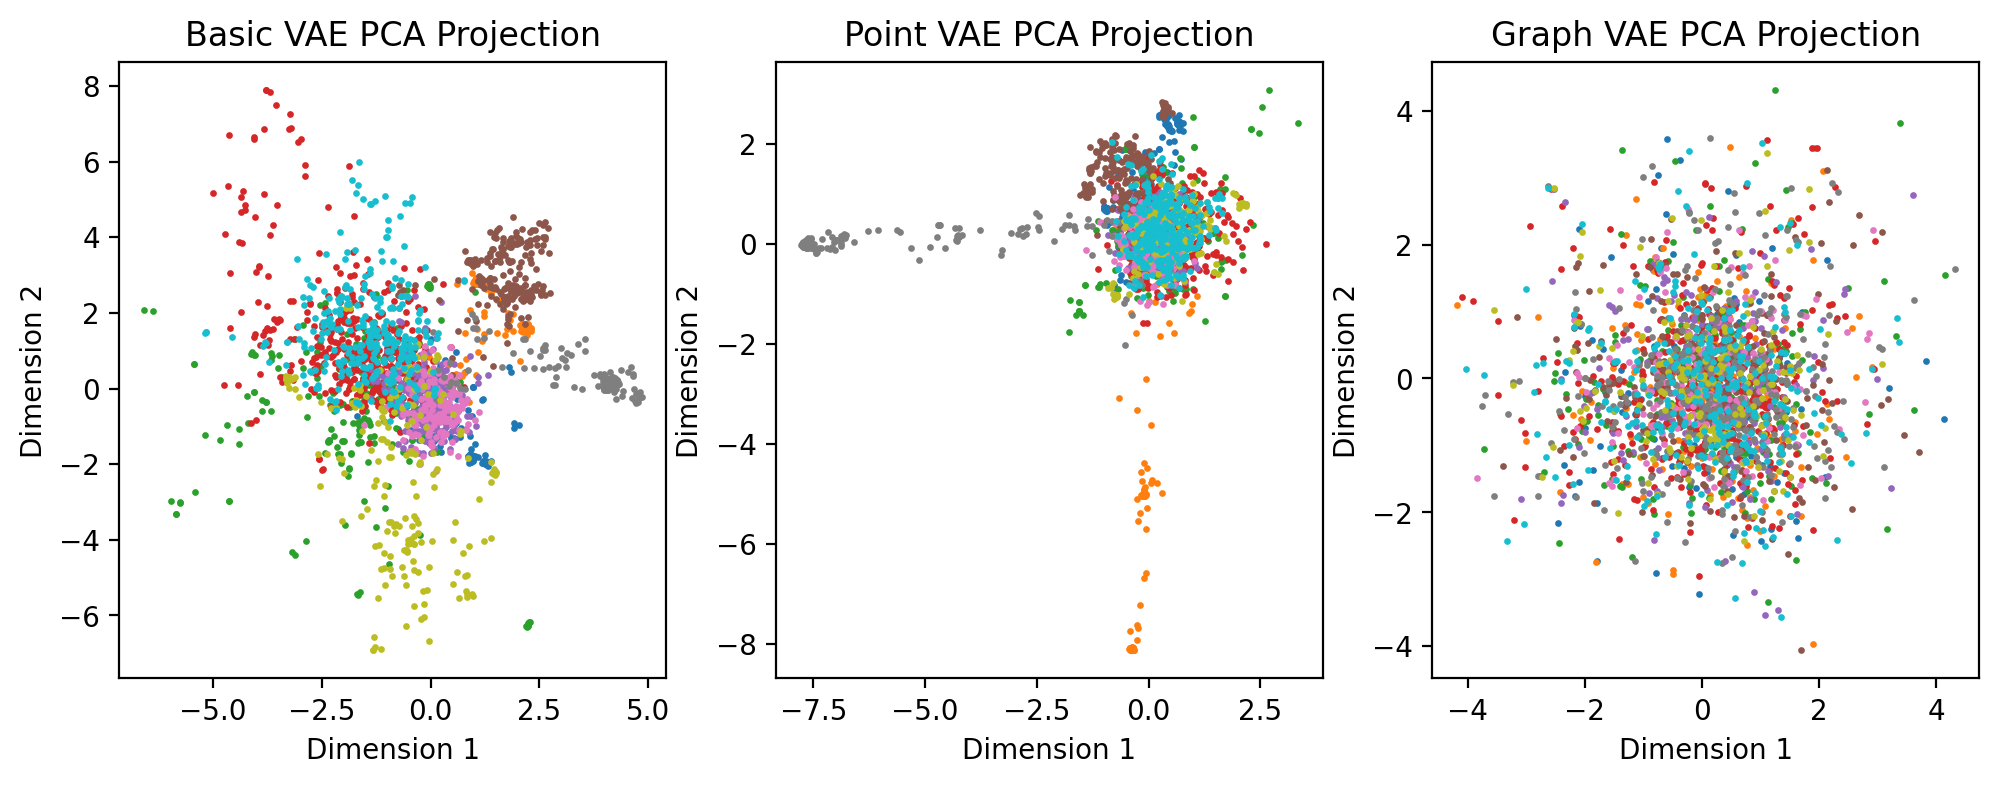

In [25]:
# plt.scatter(projected_data[:,0], projected_data[:,1], s = 2, color = 'b')
fig , axes = plt.subplots(1,3, figsize = (12,4), dpi = 200)
models = ['Basic VAE', 'Point VAE', 'Graph VAE']
for idx, proj_data in enumerate(projected_data_results):
    for i in list(np.unique(top_family_labels)[:10]):

        axes[idx].scatter(proj_data[np.where(top_family_labels == i)[0], 0], proj_data[np.where(top_family_labels == i)[0], 1], s = 2, label = i)
        axes[idx].set_xlabel('Dimension 1')
        axes[idx].set_ylabel('Dimension 2')
        axes[idx].set_title(f'{models[idx]} PCA Projection')


In [20]:
for i in projected_data_results:
    sil_score = silhouette_score(i, top_family_labels)
    db_score = davies_bouldin_score(i, top_family_labels)
    print(f"Silhouette Score: {sil_score:.3f}, Davies-Bouldin Index: {db_score:.3f}")

Silhouette Score: 0.075, Davies-Bouldin Index: 4.184
Silhouette Score: 0.043, Davies-Bouldin Index: 8.664
Silhouette Score: -0.062, Davies-Bouldin Index: 64.614


## Get Scores as number of families increases

In [21]:
latent_results = [seq_result, point_result, graph_result] 


sil_results = [[],[], []]
db_results = [[],[] ,[]]

# INSERT GRAPH

for num_families in range(5,105,5):
    top_fam = [i[0] for i in counter.most_common(num_families)[:num_families]]
    top_fam_idx = np.array([idx for idx, k in enumerate(seq_dataset.org_protein_data) if k[1]['protein']['Pfam'][0] in top_fam])
    top_fam_labels = np.array([k[1]['protein']['Pfam'][0] for idx, k in enumerate(seq_dataset.org_protein_data) if k[1]['protein']['Pfam'][0] in top_fam])

    for idx, i in enumerate(latent_results):
        
        top_input = i[top_fam_idx, :]
        sil_score = silhouette_score(top_input, top_fam_labels)
        db_score = davies_bouldin_score(top_input, top_fam_labels)

        sil_res = sil_results[idx]
        sil_res.append(sil_score)
        sil_results[idx] = sil_res

        db_res = db_results[idx]
        db_res.append(db_score)
        db_results[idx] = db_res

sil_results = np.array(sil_results)
db_results = np.array(db_results)
        

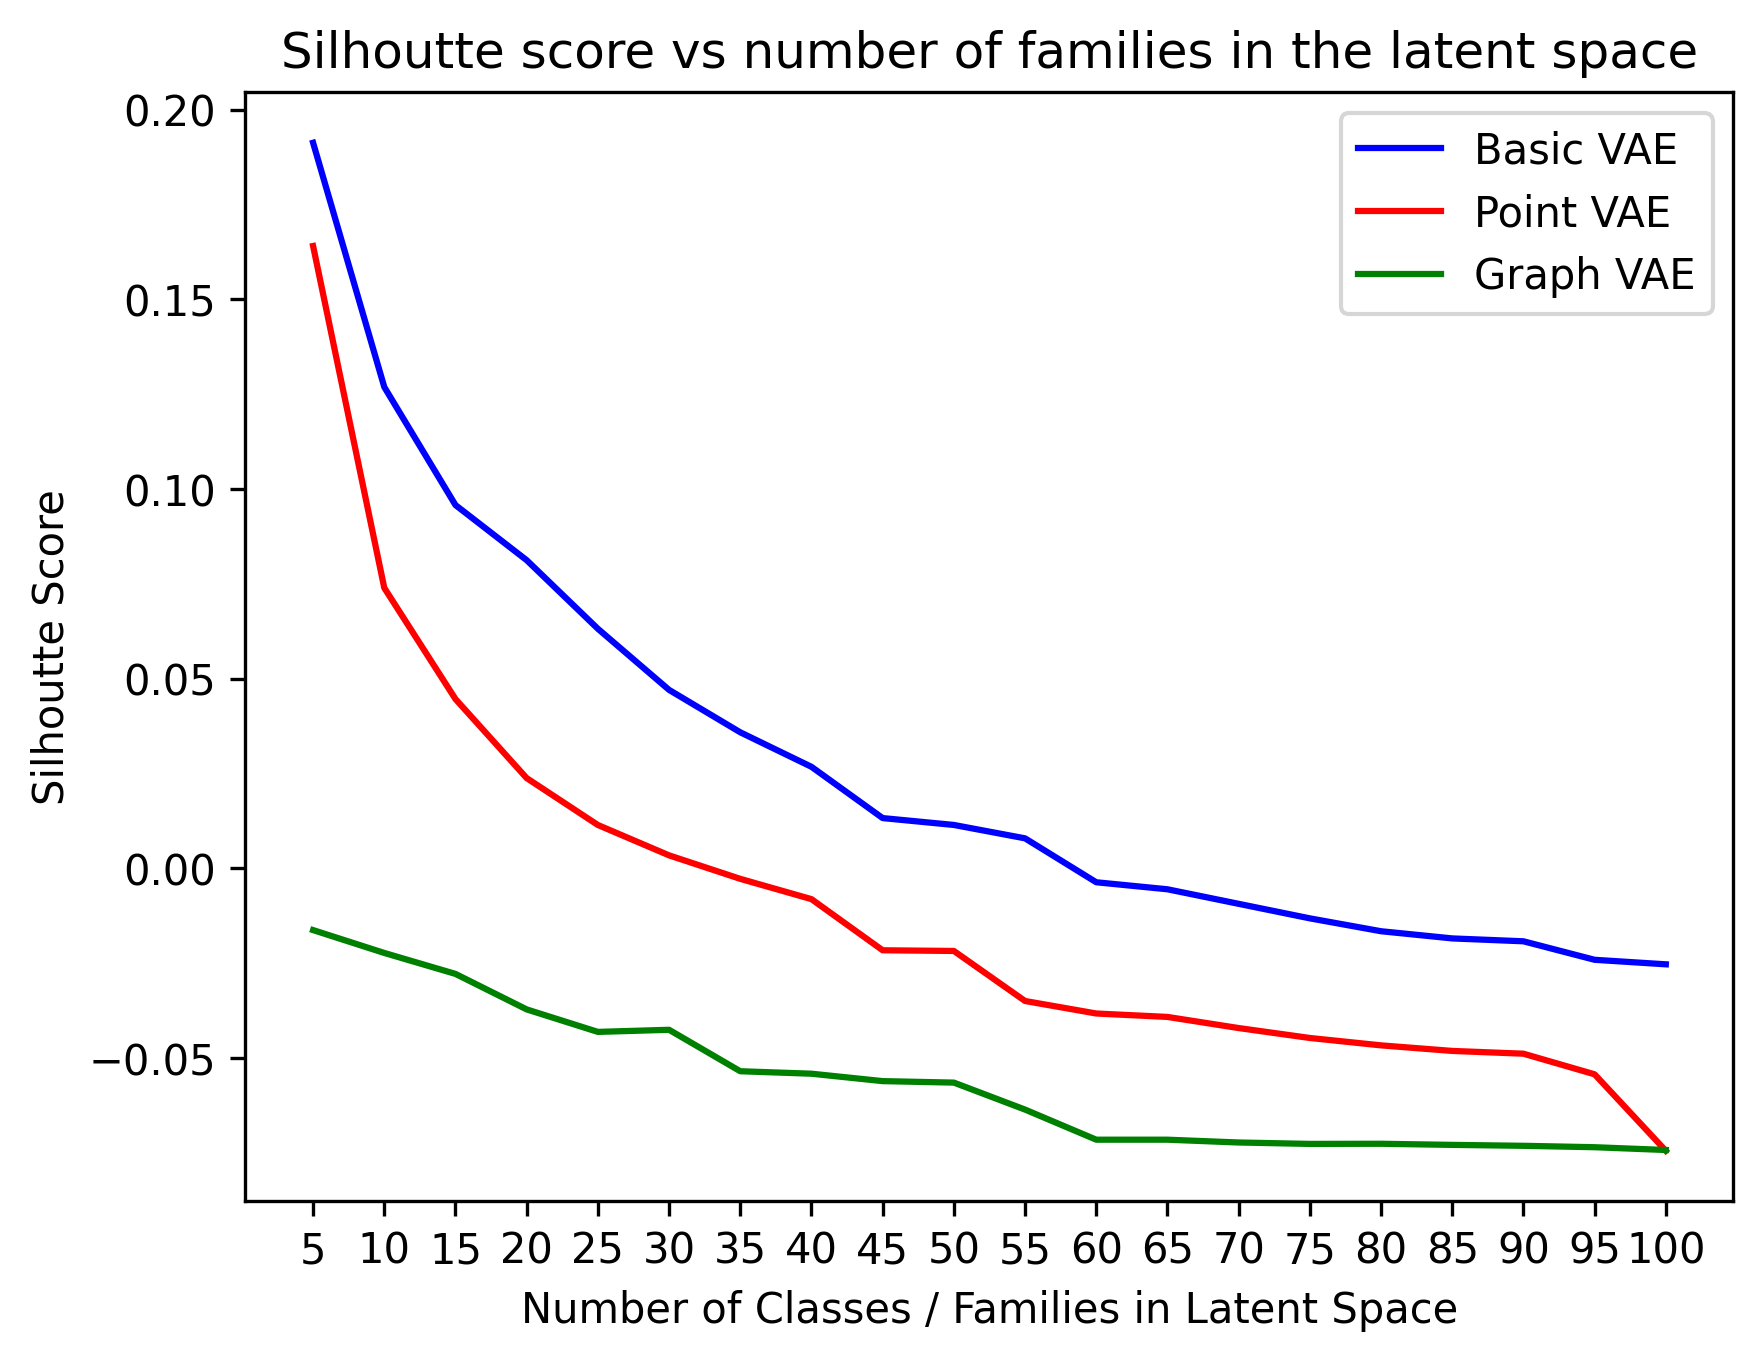

In [247]:
plt.figure(dpi = 300)
plt.plot( np.array([i for i in range(5,105,5)]),sil_results.T[:,0], label = 'Basic VAE', color = 'b')
plt.plot( np.array([i for i in range(5,105,5)]),sil_results.T[:,1], label = 'Point VAE', color = 'r')
plt.plot( np.array([i for i in range(5,105,5)]),sil_results.T[:,2], label = 'Graph VAE', color = 'g')
plt.xticks([i for i in range(5,105,5)])
plt.ylabel('Silhoutte Score')
plt.xlabel('Number of Classes / Families in Latent Space')
plt.legend()
plt.title('Silhoutte score vs number of families in the latent space')
plt.show()

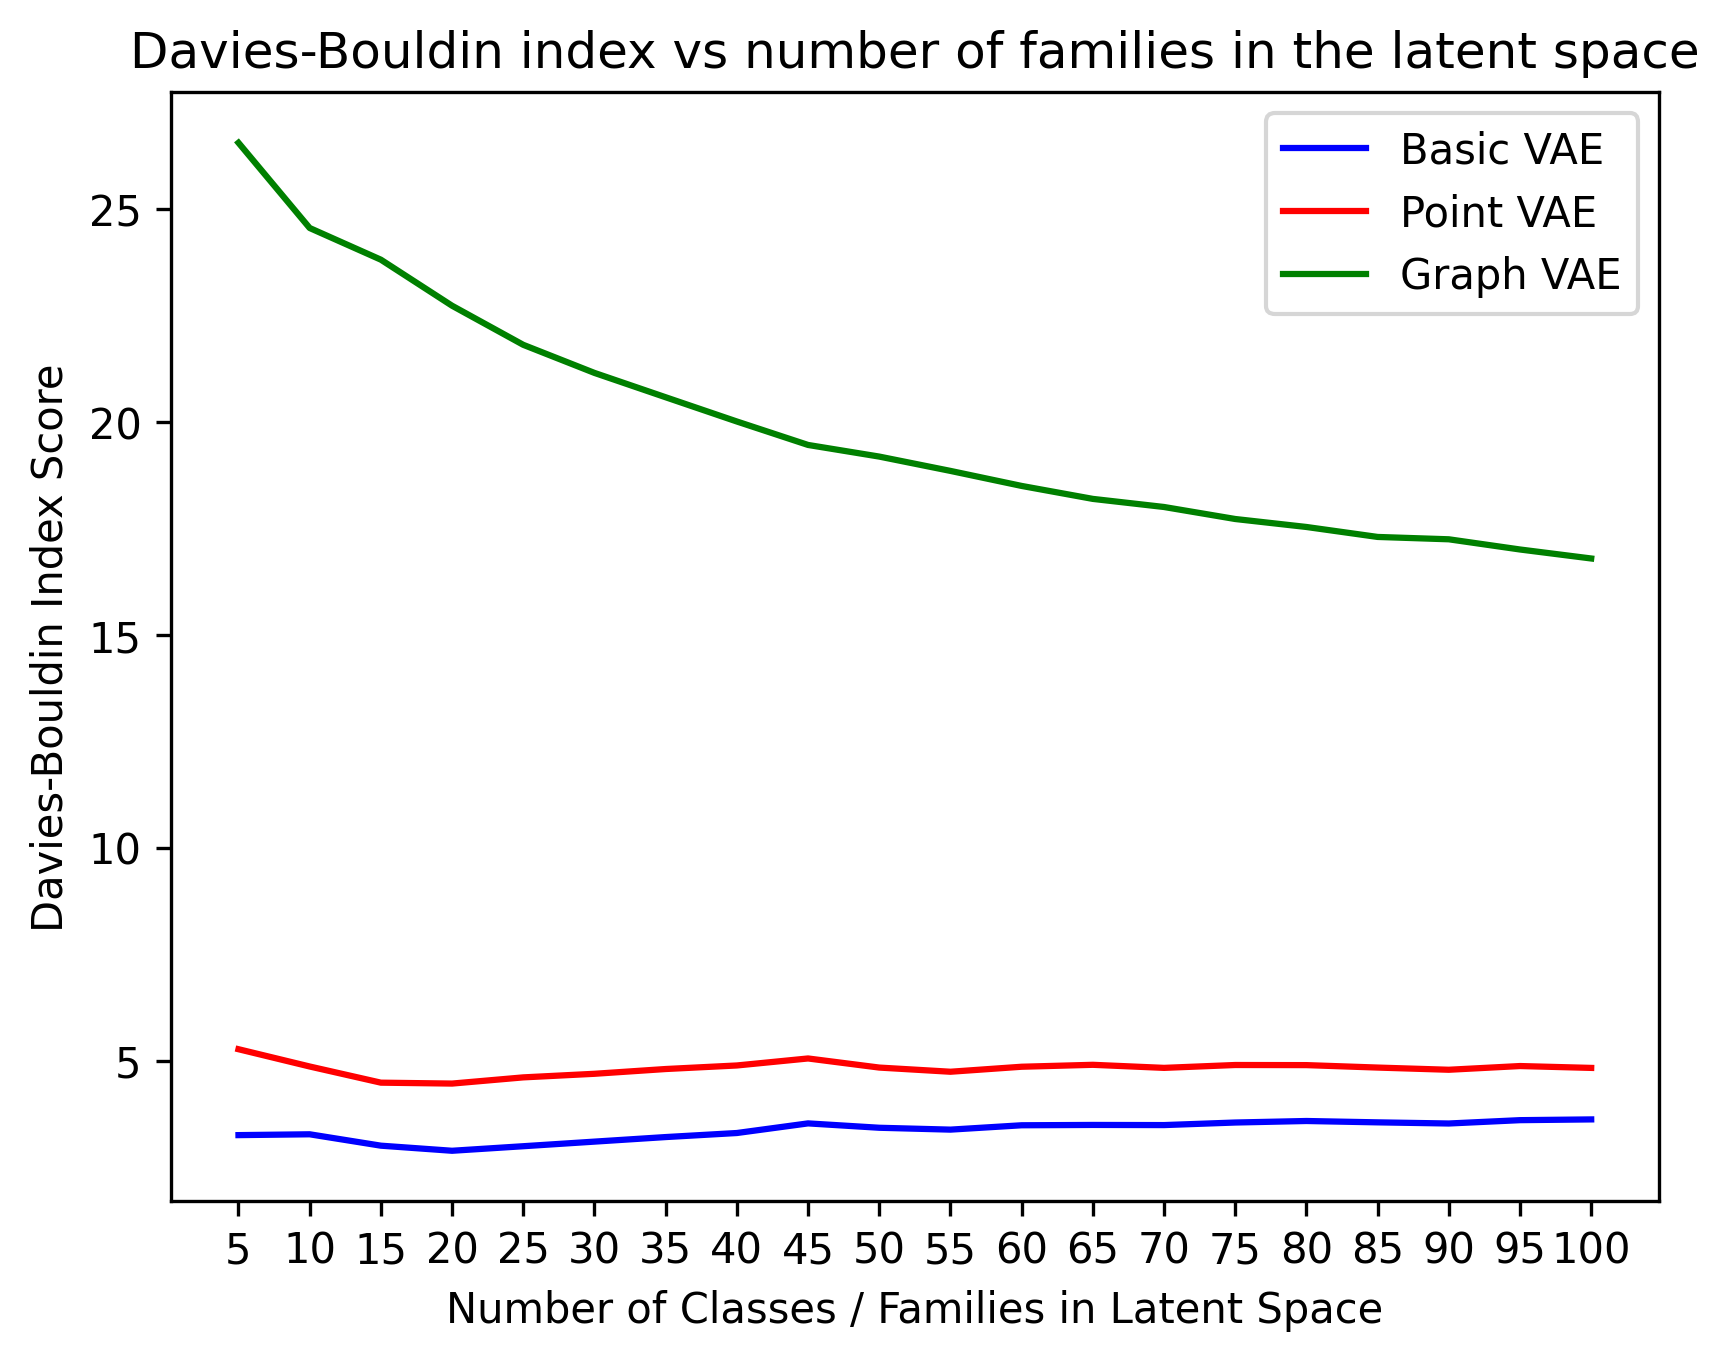

In [249]:
plt.figure(dpi = 300)
plt.plot( np.array([i for i in range(5,105,5)]),db_results.T[:,0], label = 'Basic VAE', color = 'b')
plt.plot( np.array([i for i in range(5,105,5)]),db_results.T[:,1], label = 'Point VAE', color = 'r')
plt.plot( np.array([i for i in range(5,105,5)]),db_results.T[:,2], label = 'Graph VAE', color = 'g')
plt.xticks([i for i in range(5,105,5)])
plt.ylabel('Davies-Bouldin Index Score')
plt.xlabel('Number of Classes / Families in Latent Space')
plt.title('Davies-Bouldin index vs number of families in the latent space')
plt.legend()
plt.show()

# RandomForest Model

In [251]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold, train_test_split
import joblib

param_save_file = ['Basic', 'Point', 'Graph']
top_families_vals = [5, 10, 20, 40, 60, 80, 100]

param_grid = {
    'n_estimators': [i for i in range(100,200,20)],
    'max_depth': [i for i in range(10,50,10)],
    'min_samples_split': [i for i in range(5,20,5)],
    'min_samples_leaf': [i for i in range(1,11,2)],
    'max_features': ['sqrt', 'log2']
}


for idx, model_result in enumerate([seq_result, point_result, graph_result]):
    num_families = top_families_vals[0]
    top_fam = [i[0] for i in counter.most_common(num_families)]
    top_fam_dict_map = {fam : i for i, fam in enumerate(top_fam)}

    top_fam_idx = np.array([idx for idx, k in enumerate(seq_dataset.org_protein_data) if k[1]['protein']['Pfam'][0] in top_fam])
    top_fam_labels = np.array([top_fam_dict_map[k[1]['protein']['Pfam'][0]] for k in seq_dataset.org_protein_data if k[1]['protein']['Pfam'][0] in top_fam ])

    X = model_result[top_fam_idx, :]
    y = top_fam_labels

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    rf = RandomForestClassifier(random_state=42, class_weight='balanced')

    grid_search = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        cv=cv,  # Use StratifiedKFold here
        scoring='accuracy',  # or 'accuracy', 'recall', etc.
        n_jobs=-1,
        verbose=2
    )

    # Fit the grid search
    grid_search.fit(X_train, y_train)

    # Print best parameters and score
    print("\nBest Parameters:", grid_search.best_params_)
    print("Best CV Score (f1_macro):", grid_search.best_score_)

    # Save the best parameters to a file
    best_params = grid_search.best_params_

    # Saving to a file
    joblib.dump(best_params, f'../data/Cluster_Analysis_Data/RF_{param_save_file[idx]}_best_params.pkl')



Fitting 5 folds for each of 600 candidates, totalling 3000 fits
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=120; total time=   0.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=120; total time=   0.3s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=

# Train best param model for each representation and evaluate on increasing number of protein families

In [252]:
# Load Best Parameters
import joblib
seq_rf_param_loc = '../data/Cluster_Analysis_Data/RF_Basic_best_params.pkl'
point_rf_param_loc = '../data/Cluster_Analysis_Data/RF_Point_best_params.pkl'
graph_rf_param_loc = '../data/Cluster_Analysis_Data/RF_Graph_best_params.pkl'

# Load the trained Random Forest model from the file
seq_rf_param = joblib.load(seq_rf_param_loc)
point_rf_param = joblib.load(point_rf_param_loc)
graph_rf_param = joblib.load(graph_rf_param_loc)


In [255]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
rf_acc_results = [[],[],[]]
rf_prec_results = [[],[],[]]
rf_recall_results = [[],[],[]]
rf_f1_results = [[],[],[]]

top_families_vals = [5, 10, 20, 40, 60, 80, 100]

for i in range(len(top_families_vals)):
    num_families = top_families_vals[i]
    top_fam = [i[0] for i in counter.most_common(num_families)]
    top_fam_dict_map = {fam : i for i, fam in enumerate(top_fam)}

    top_fam_idx = np.array([idx for idx, k in enumerate(seq_dataset.org_protein_data) if k[1]['protein']['Pfam'][0] in top_fam])
    top_fam_labels = np.array([top_fam_dict_map[k[1]['protein']['Pfam'][0]] for k in seq_dataset.org_protein_data if k[1]['protein']['Pfam'][0] in top_fam ])

    for idx, model_result in enumerate([seq_result, point_result, graph_result]):

        X = model_result[top_fam_idx, :]
        y = top_fam_labels

        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

        rf = RandomForestClassifier(**best_params, random_state=42, class_weight='balanced')

        # Fit the model with your data (assuming you have X_train, y_train)
        rf.fit(X_train, y_train)

        # Use the model for predictions
        y_pred = rf.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        acc_row = rf_acc_results[idx]
        acc_row.append(accuracy)
        rf_acc_results[idx] = acc_row

        # 2. Precision (for a specific class or average)
        precision = precision_score(y_test, y_pred, average='macro')  # 'micro', 'macro', 'weighted', or 'binary'
        precision_row = rf_prec_results[idx]
        precision_row.append(precision)
        rf_prec_results[idx] = precision_row


        # 3. Recall (for a specific class or average)
        recall = recall_score(y_test, y_pred, average='macro')  # Same options as precision
        recall_row = rf_recall_results[idx]
        recall_row.append(recall)
        rf_recall_results[idx] = recall_row
        print(f"Recall: {recall:.4f}")

        # 4. F1 Score
        f1 = f1_score(y_test, y_pred, average='macro')  # Can also use 'micro', 'weighted'
        f1_row = rf_f1_results[idx]
        f1_row.append(f1)
        rf_f1_results[idx] = f1_row
        print(f"F1 Score: {f1:.4f}")


Recall: 0.8430
F1 Score: 0.8528
Recall: 0.8571
F1 Score: 0.8695
Recall: 0.1819
F1 Score: 0.1772
Recall: 0.8272
F1 Score: 0.8318
Recall: 0.8257
F1 Score: 0.8379
Recall: 0.1109
F1 Score: 0.1104
Recall: 0.7901
F1 Score: 0.7895
Recall: 0.7572
F1 Score: 0.7665
Recall: 0.0382
F1 Score: 0.0390
Recall: 0.6172
F1 Score: 0.6138
Recall: 0.6033
F1 Score: 0.6005
Recall: 0.0199
F1 Score: 0.0179
Recall: 0.5882
F1 Score: 0.5753
Recall: 0.5777
F1 Score: 0.5677
Recall: 0.0207
F1 Score: 0.0176
Recall: 0.5273
F1 Score: 0.5167
Recall: 0.5025
F1 Score: 0.4878
Recall: 0.0119
F1 Score: 0.0094
Recall: 0.5105
F1 Score: 0.5039
Recall: 0.4687
F1 Score: 0.4395
Recall: 0.0099
F1 Score: 0.0084


/opt/anaconda3/envs/ProteinManifoldLearning/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


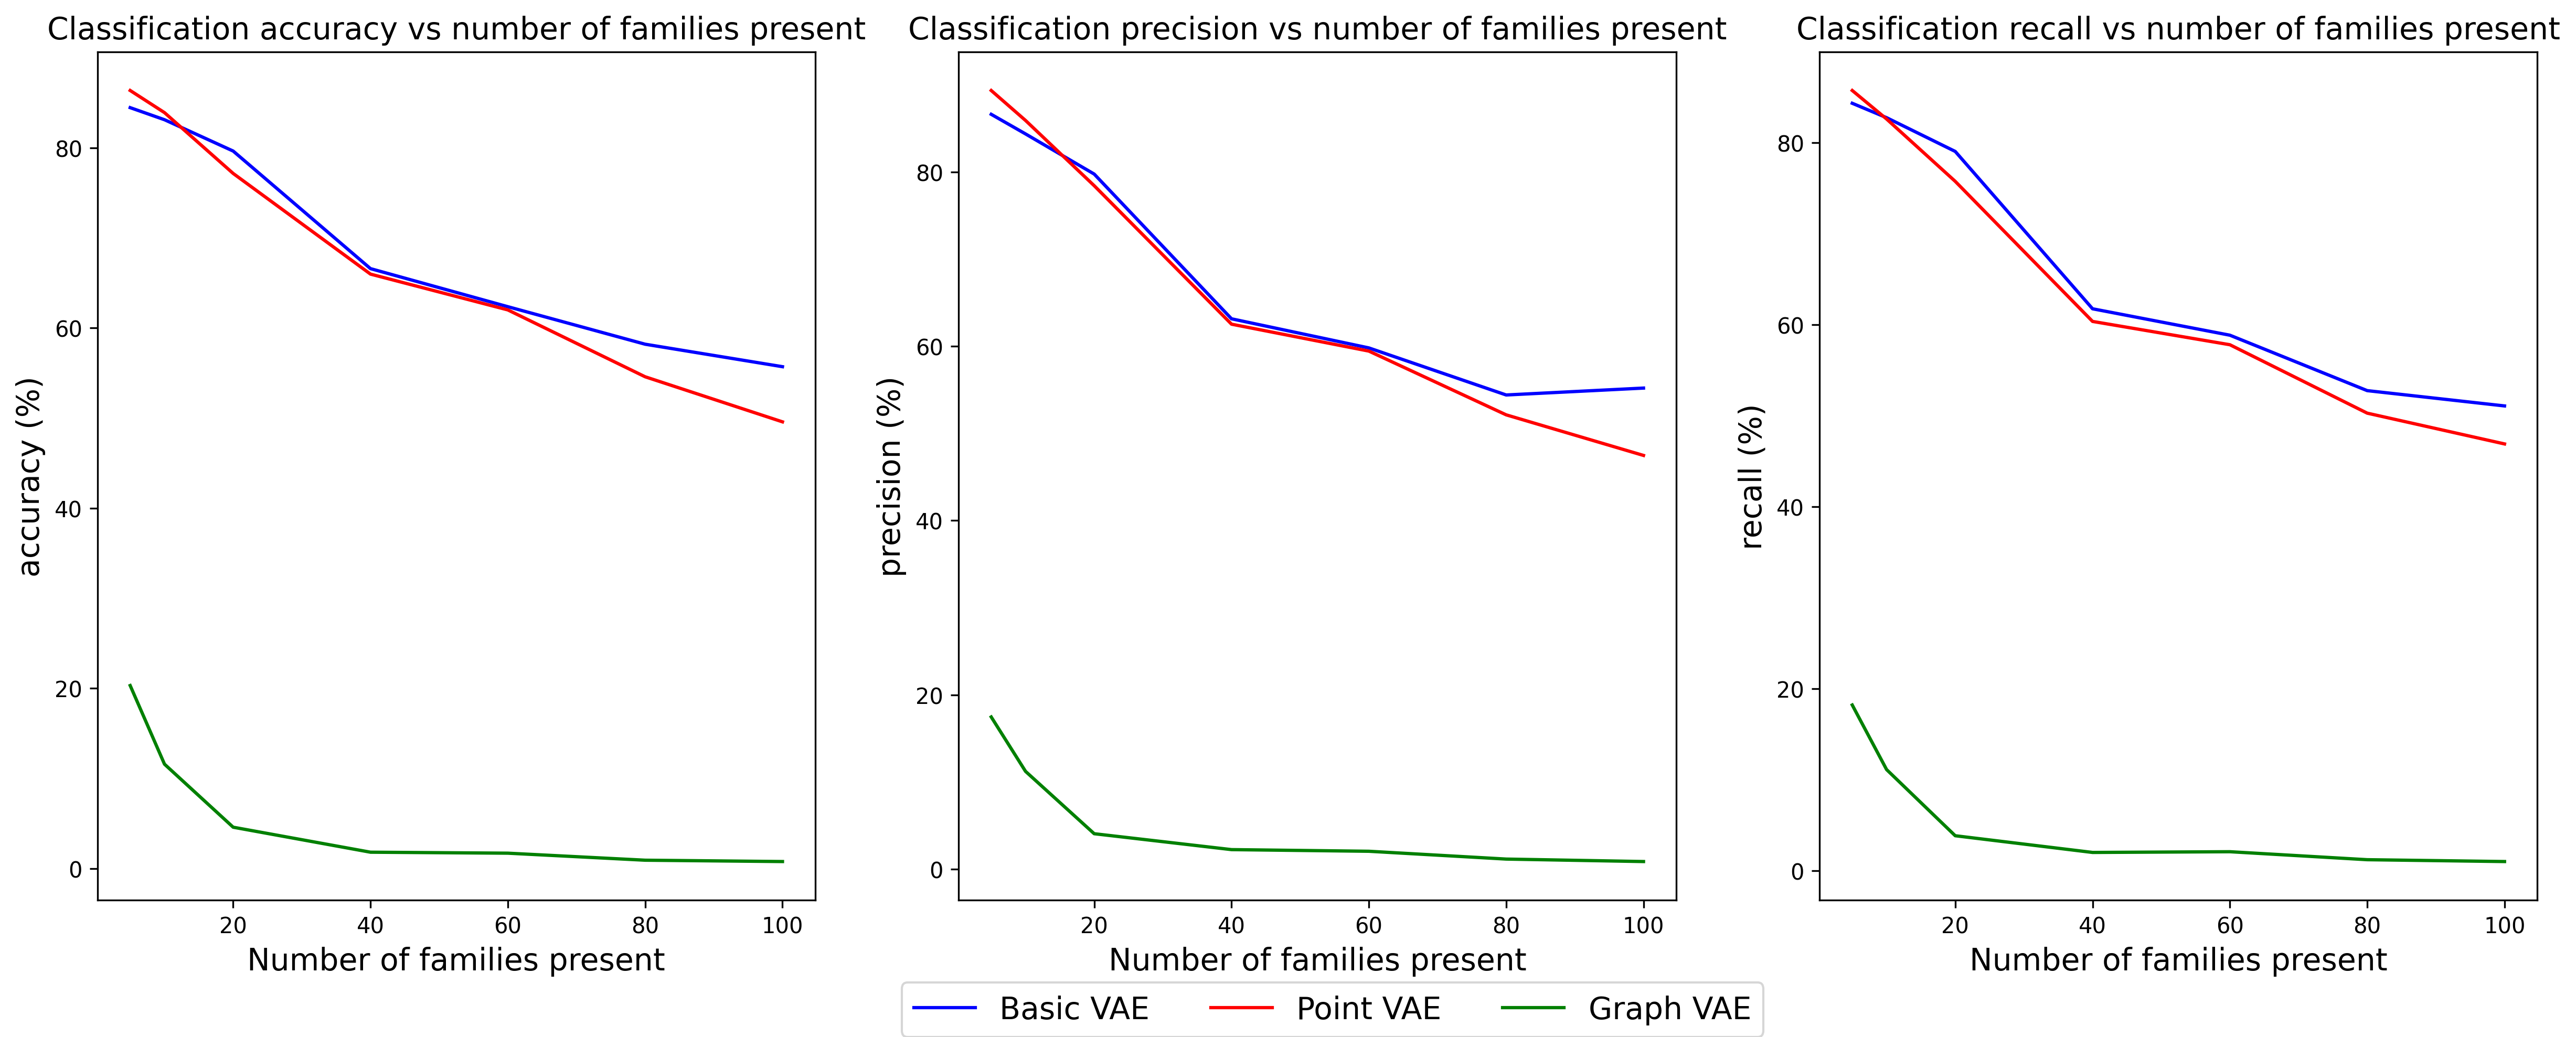

In [324]:
result_arrays = [np.array(rf_acc_results).T, np.array(rf_prec_results).T, np.array(rf_recall_results).T, np.array(rf_f1_results).T]
result_titles = ['accuracy', 'precision', 'recall']
model_label = ['Basic VAE', 'Point VAE', 'Graph VAE']
model_colour = ['b', 'r', 'g']

family_value_array = np.array([5, 10, 20, 40, 60, 80, 100])
fig, axes = plt.subplots(1,3, dpi = 300, figsize = (20,7))
axes = axes.flatten()
for idx, title in enumerate(result_titles):
    result_array = result_arrays[idx]
    axes[idx].set_title(f'Classification {title} vs number of families present', fontsize = 14)
    for model_idx in range(3):
        if idx == 0:
            axes[idx].plot(family_value_array, result_array[:, model_idx]*100, label = model_label[model_idx], color = model_colour[model_idx])
        else:
            axes[idx].plot(family_value_array, result_array[:, model_idx]*100, color = model_colour[model_idx])
        axes[idx].set_xlabel('Number of families present', size = 14)
        axes[idx].set_ylabel(f'{title} (%)', size = 14)

fig.legend(loc=(0.35,0), ncol=3, fontsize = 14)

